In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sys

import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression

from sklearn import metrics


from sklearn import  linear_model
from sklearn.metrics import mean_squared_error, r2_score

C:\Users\Creative\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Creative\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:

data = pd.read_csv('../static/flights.csv')

In [3]:
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

In [4]:
data.head(4)

,MONTH,DAY,WEEKDAY,AIRLINE,ORG_AIR,DEST_AIR,SCHED_DEP,DEP_DELAY,AIR_TIME,DIST,SCHED_ARR,ARR_DELAY,DIVERTED,CANCELLED
0,1,1,4,WN,LAX,SLC,1625,58.0,94.0,590,1905,65.0,0,0
1,1,1,4,UA,DEN,IAD,823,7.0,154.0,1452,1333,-13.0,0,0
2,1,1,4,MQ,DFW,VPS,1305,36.0,85.0,641,1453,35.0,0,0
3,1,1,4,AA,DFW,DCA,1555,7.0,126.0,1192,1935,-7.0,0,0


In [5]:
#Two news binary columns to track delay and on time arrives 

data['DELAYED'] = data['ARR_DELAY'].ge(15).astype(int)
cols = ['DIVERTED', 'CANCELLED', 'DELAYED']
data['ON_TIME'] = 1 - data[cols].any(axis=1)

cols.append('ON_TIME')
status = data[cols].sum()
status

DIVERTED       137
CANCELLED      881
DELAYED      11685
ON_TIME      45789
dtype: int64

# Statitics on each airline

In [70]:
stats = data['DEP_DELAY'].groupby(data['AIRLINE']).apply(get_stats).unstack()

stats = stats.sort_values('count')
stats

,count,max,mean,min
AIRLINE,,,,
HA,112.0,298.0,2.571429,-24.0
B6,542.0,348.0,14.287823,-19.0
AS,768.0,338.0,1.808594,-22.0
VX,987.0,253.0,8.918946,-13.0
F9,1308.0,852.0,14.310398,-19.0
NK,1493.0,461.0,19.514401,-16.0
US,1594.0,439.0,4.361355,-15.0
MQ,3329.0,342.0,11.094323,-12.0
EV,5722.0,672.0,9.092625,-17.0


# Visualizing the flights dataset

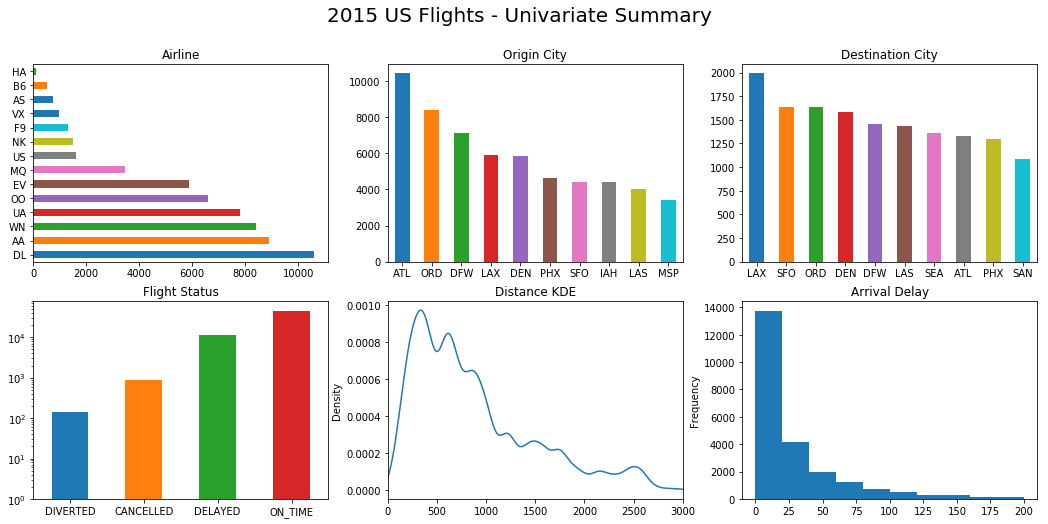

In [71]:
#Two by three grid = figsize axis
# Each of the plot method references specific axis in the fig (ax=ax1)
#value count is used to created the three series that forms the plots in the top row
#the rot parameter rotate the tick labels
fig, ax_array = plt.subplots(2, 3, figsize=(18,8))

(ax1, ax2, ax3), (ax4, ax5, ax6) = ax_array
fig.suptitle('2015 US Flights - Univariate Summary', size=20)

ac = data['AIRLINE'].value_counts()
ac.plot(kind='barh', ax=ax1, title ='Airline')

oc = data['ORG_AIR'].value_counts()
oc.plot(kind='bar', ax=ax2, rot=0, title='Origin City')

dc = data['DEST_AIR'].value_counts().head(10)
dc.plot(kind='bar', ax=ax3, rot=0, title='Destination City')

status.plot(kind='bar', ax=ax4, rot=0, log=True, title='Flight Status')
data['DIST'].plot(kind='kde', ax=ax5, xlim=(0, 3000),
                     title='Distance KDE')
data['ARR_DELAY'].plot(kind='hist', ax=ax6, 
                          title='Arrival Delay', range=(0,200))

In [72]:
#Plotting flights per week
# time series plot with dates on axis
# Pass DataFrame to datetime function, return secuence of TimeStamps 

In [80]:
# Add a column for the year, and use the schedule departure time to get the hour and the minute
hour = data['SCHED_DEP'] // 100
minute = data['SCHED_DEP'] % 100
df_date = data[['MONTH', 'DAY']].assign(YEAR=2015, HOUR=hour, MINUTE=minute)
df_date.head()

,MONTH,DAY,HOUR,MINUTE,YEAR
0,1,1,16,25,2015
1,1,1,8,23,2015
2,1,1,13,5,2015
3,1,1,15,55,2015
4,1,1,17,20,2015


In [81]:
flight_dep = pd.to_datetime(df_date)
flight_dep.head()

0   2015-01-01 16:25:00
1   2015-01-01 08:23:00
2   2015-01-01 13:05:00
3   2015-01-01 15:55:00
4   2015-01-01 17:20:00
dtype: datetime64[ns]

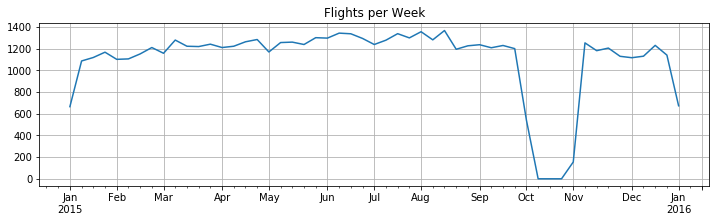

In [82]:
# Resampling method:for frequency conversion and resampling of time series

data.index = flight_dep
fc = data.resample('W').size()
fc.plot(figsize=(12,3), title='Flights per Week', grid=True)


Text(0.5,1,'Flights per Week (Interpolated Missing Data)')

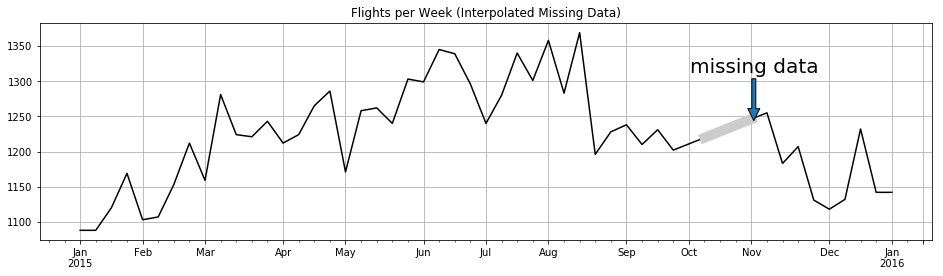

In [83]:
#  interpolate method to fill in this missing data
fc_miss = fc.where(fc >  1000)
fc_intp = fc_miss.interpolate(limit_direction='both')

ax = fc_intp.plot(color='black', figsize=(16,4))
fc_intp[fc < 500].plot(linewidth=10, grid=True, 
                       color='.8', ax=ax)

ax.annotate(xy=(.8, .55), xytext=(.8, .77), 
            xycoords='axes fraction', s='missing data', 
            ha='center',  size=20, arrowprops=dict())
ax.set_title('Flights per Week (Interpolated Missing Data)')


In [84]:
#Multivariable plotting
#Have the longest average distance traveled for departure flights


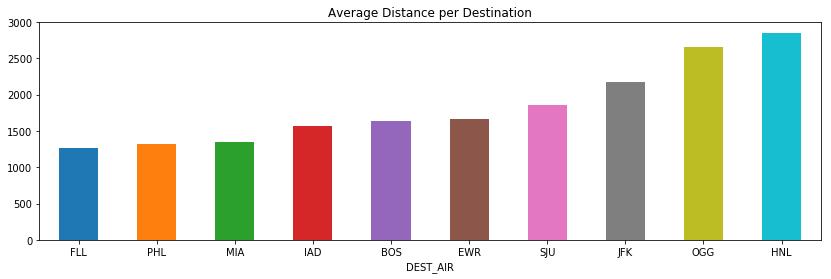

In [85]:
data.groupby('DEST_AIR')['DIST'] \
       .agg(['mean', 'count']) \
       .query('count > 100') \
       .sort_values('mean') \
       .tail(10) \
       .plot(kind='bar', y='mean', legend=False, 
             rot=0, figsize=(14,4),
             title='Average Distance per Destination')

Linear Regression  on How is the time of a flight related to the distance of the flight?


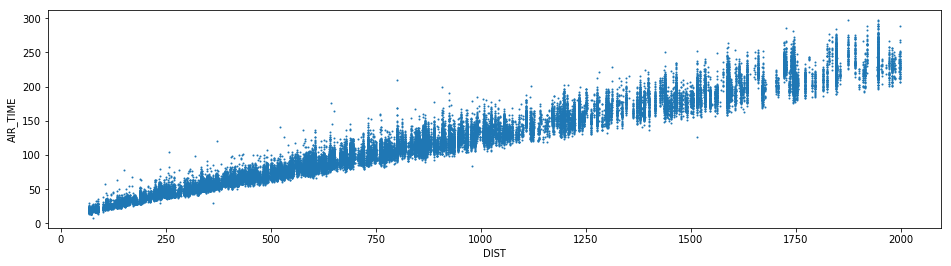

In [86]:
# scatter plot between distance and airtime under 2000 miles
fs = data.reset_index(drop=True)[['DIST', 'AIR_TIME']].query('DIST <= 2000').dropna()
fs.plot(x='DIST', y='AIR_TIME', kind='scatter', s=1, figsize=(16,4))

It shows linear relationship exists between distance and airtime


In [87]:
#Grouping Flight distances into eight groups


fs['DIST_GROUP'] = pd.cut(fs['DIST'], bins=range(0, 2001, 250))
fs['DIST_GROUP'].value_counts().sort_index()

(0, 250]         6529
(250, 500]      12631
(500, 750]      11506
(750, 1000]      8832
(1000, 1250]     5071
(1250, 1500]     3198
(1500, 1750]     3885
(1750, 2000]     1815
Name: DIST_GROUP, dtype: int64

In [88]:
fs.head(4)

,DIST,AIR_TIME,DIST_GROUP
0,590,94.0,"(500, 750]"
1,1452,154.0,"(1250, 1500]"
2,641,85.0,"(500, 750]"
3,1192,126.0,"(1000, 1250]"


In [89]:
# Calculate for each flight the number of standard deviations 

In [90]:
normalize = lambda x: (x - x.mean()) / x.std()
fs['TIME_SCORE'] = fs.groupby('DIST_GROUP')['AIR_TIME'] \
                     .transform(normalize)

fs.head(10)

,DIST,AIR_TIME,DIST_GROUP,TIME_SCORE
0,590,94.0,"(500, 750]",0.490966
1,1452,154.0,"(1250, 1500]",-1.267551
2,641,85.0,"(500, 750]",-0.296749
3,1192,126.0,"(1000, 1250]",-1.211020
4,1363,166.0,"(1250, 1500]",-0.521999
5,1303,178.0,"(1250, 1500]",0.223553
6,447,64.0,"(250, 500]",0.639752
7,651,91.0,"(500, 750]",0.228394
8,258,44.0,"(250, 500]",-1.466326
9,1608,215.0,"(1500, 1750]",0.508643


Text(0.5,0.98,'')

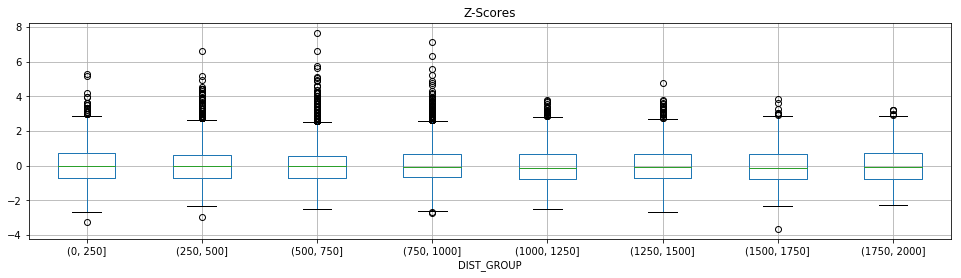

In [91]:
ax = fs.boxplot(by='DIST_GROUP', column='TIME_SCORE', figsize=(16,4))
ax.set_title('Z-Scores')
ax.figure.suptitle('')


In [92]:
# DataFrame with just the outliers

Points that are greater than six standard deviations away from the mean.

In [94]:
outliers = data.iloc[fs[fs['TIME_SCORE'] > 6].index]
outliers = outliers[['AIRLINE','ORG_AIR', 'DEST_AIR', 'AIR_TIME', 
                     'DIST', 'ARR_DELAY', 'DIVERTED']]
outliers['PLOT_NUM'] = range(1, len(outliers) + 1)
outliers

,AIRLINE,ORG_AIR,DEST_AIR,AIR_TIME,DIST,ARR_DELAY,DIVERTED,PLOT_NUM
2015-04-08 09:40:00,DL,ATL,CVG,121.0,373,54.0,0,1
2015-05-25 16:30:00,F9,MSP,ATL,199.0,907,79.0,0,2
2015-09-10 20:00:00,UA,IAH,MCI,176.0,643,76.0,0,3
2015-12-10 19:53:00,OO,PHX,SFO,164.0,651,146.0,0,4
2015-12-26 09:15:00,NK,ORD,DFW,210.0,802,98.0,0,5


In [95]:
#Identify the outliers on the plot 

Text(0.5,1,'Flight Time vs Distance with Outliers')

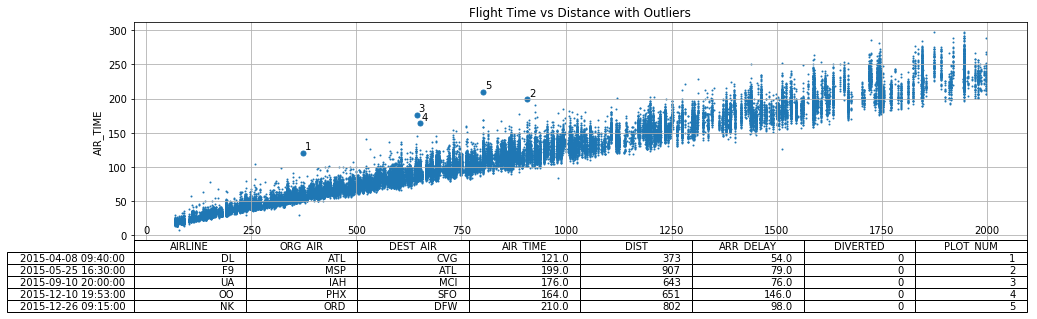

In [96]:
ax = fs.plot(x='DIST', y='AIR_TIME', 
             kind='scatter', s=1, 
             figsize=(16,4), table=outliers)
outliers.plot(x='DIST', y='AIR_TIME',
              kind='scatter', s=25, ax=ax, grid=True)

outs = outliers[['AIR_TIME', 'DIST', 'PLOT_NUM']]
for t, d, n  in outs.itertuples(index=False):
    ax.text(d + 5, t + 5, str(n))
    
plt.setp(ax.get_xticklabels(), y=.1)
plt.setp(ax.get_xticklines(), visible=False)
ax.set_xlabel('')
ax.set_title('Flight Time vs Distance with Outliers')

In [249]:
#Departure Airport and Delays
print("Nb of airports: {}".format(len(data['ORG_AIR'].unique())))

Nb of airports: 10


In [97]:

#Passing Categoprical to ordinal
data['AIRLINE']= data.AIRLINE.astype('category').cat.codes
data['ORG_AIR']= data.ORG_AIR.astype('category').cat.codes
data['DEST_AIR']= data.DEST_AIR.astype('category').cat.codes

In [98]:
#Missing values
missing_data = data.isnull().sum(axis=0).reset_index()
missing_data.columns = ['variable', 'missing values']
missing_data['filling factor (%)']=(data.shape[0]-missing_data['missing values'])/data.shape[0]*100
missing_data.sort_values('filling factor (%)').reset_index(drop = True)

data.dropna(inplace = True)

Random Forest

In [99]:



n= data
# split data into two
train_data, test_data = train_test_split(n, test_size=0.33)
x_train = train_data.drop("AIR_TIME", axis=1)
y_train = train_data['AIR_TIME']

x_test = test_data.drop(["AIR_TIME"], axis=1)
y_test = test_data['AIR_TIME']

# create and fit the forest
forest = RandomForestRegressor(n_estimators=100)
forest.fit(x_train, y_train)

# predict
y_pred = forest.predict(x_test)

# print the score
forest_score = round(forest.score(x_test, y_test) * 100, 2)
print(forest_score)

99.11


In [100]:
from sklearn.externals import joblib

joblib.dump(forest_score, 'test.pkl') 

['test.pkl']

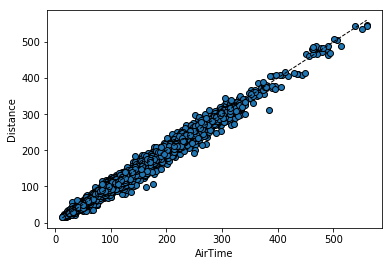

In [61]:

# plot  the time and distance travelled by the flights
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('AirTime')
ax.set_ylabel('Distance')
plt.show()